In [25]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import statsmodels.api as sm 

from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Combine and Tidy Data Sources

In [2]:
djia = pd.read_csv("data/^DJI.csv")
confirmed = pd.read_csv("data/time_series_19-covid-Confirmed.csv")
deaths = pd.read_csv("data/time_series_19-covid-Deaths.csv")
recovered = pd.read_csv("data/time_series_19-covid-Recovered.csv")

In [3]:
djia = djia[djia['Date'] >= '2020-01-01']
djia['Date']=djia['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [4]:
with sqlite3.connect('data/newspaper.db') as conn:
    articles = pd.read_sql("""
                            SELECT * FROM articles
                            WHERE date NOT NULL
                            AND text NOT NULL
                            """, conn)

In [5]:
articles['date'] = articles['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
articles = articles[articles['date'] >= datetime(2020,1,1)]

In [6]:
# tidy 3 dfs
melt_ids = ['Province/State', 'Country/Region', 'Lat', 'Long']

tidy_confirmed = confirmed.melt(id_vars=melt_ids, 
                               value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                               var_name='Date', value_name='Confirmed')

tidy_deaths = deaths.melt(id_vars=melt_ids, 
                               value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                               var_name='Date', value_name='Deaths')

tidy_recovered = recovered.melt(id_vars=melt_ids, 
                                value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                                var_name='Date', value_name='Recovered')


# merge 3 dfs
melt_ids.append('Date')
df = pd.merge(pd.merge(tidy_confirmed, tidy_deaths, on=melt_ids), 
                         tidy_recovered, on=melt_ids)

# tidy merged df
tidy_df = df.melt(id_vars=melt_ids, 
                  value_vars=['Confirmed', 'Deaths', 'Recovered'],
                  var_name='Type', 
                  value_name='Count')

# format date col
tidy_df['Date']=tidy_df['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [53]:
# counts by country/region
tidy_df = tidy_df.drop(['Lat', 'Long'],axis=1).groupby(['Country/Region', 'Type', 'Date']).sum().reset_index()

# counts by US/Non-US
tidy_df['US'] = tidy_df['Country/Region'] == 'US'
tidy_df['US'].replace(True, 'US', inplace=True)
tidy_df['US'].replace(False, 'Non-US', inplace=True)
tidy_df = tidy_df.groupby(['US', 'Date', 'Type']).sum().reset_index()

##### Sample

In [7]:
tidy_df.sample(5)

,Province/State,Country/Region,Lat,Long,Date,Type,Count
11244,"Madera County, CA",US,37.2519,-119.6963,2020-01-25,Deaths,0
22798,"Travis, CA (From Diamond Princess)",US,38.2721,-121.9399,2020-01-31,Recovered,0
22935,"Clark County, WA",US,45.7466,-122.5194,2020-01-31,Recovered,0
1710,"Washington County, OR",US,45.5470,-123.1386,2020-01-29,Confirmed,0
9384,"San Francisco County, CA",US,37.7749,-122.4194,2020-03-03,Confirmed,0


In [8]:
djia.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
233,2020-02-10,28995.660156,29278.070313,28995.660156,29276.820313,29276.820313,250510000
251,2020-03-06,25457.210938,25994.380859,25226.619141,25864.779297,25864.779297,599780000
234,2020-02-11,29390.710938,29415.390625,29210.470703,29276.339844,29276.339844,279540000
210,2020-01-07,28639.179688,28685.500000,28565.279297,28583.679688,28583.679688,258900000
243,2020-02-25,28037.650391,28149.199219,26997.619141,27081.359375,27081.359375,513270000


In [9]:
articles.sample(5)

,site,link,title,authors,date,text
4434,cnn,https://www.cnn.com/2020/03/08/politics/bernie...,6 key moments from Bernie Sanders' interview w...,Devan Cole,2020-03-08,In a wide-ranging interview Sunday with CNN's ...
1517,nytimes,https://www.nytimes.com/reuters/2020/02/25/wor...,Iranian Security Official Accuses White House ...,None,2020-02-25,Advertisement Supported by By Reuters DUBAI —...
2886,nytimes,https://www.nytimes.com/2020/03/01/health/coro...,"Coronavirus May Have Spread in U.S. for Weeks,...","Sheri Fink, Mike Baker",2020-03-01,Advertisement Supported by Two cases detected ...
224,cnn,https://www.cnn.com/2020/02/28/tech/korea-coro...,Coronavirus mobile apps are surging in popular...,"Ivan Watson, Sophie Jeong, Cnn Business",2020-02-28,Mobile apps that help track the disease in Sou...
3388,nytimes,https://www.nytimes.com/2020/03/04/briefing/su...,"Super Tuesday, Coronavirus, Supreme Court: You...",Chris Stanford,2020-03-04,Advertisement Supported by By Chris Stanford (...


## Questions to Answer

### 1. Are news companies portraying the Coronavirus situation objectively?

In [10]:
from textblob import TextBlob

In [11]:
def subjectivity_analysis(text):
    return TextBlob(text).sentiment.subjectivity

In [14]:
color_map = {'cnn':'red', 'nytimes':'blue'}

In [12]:
articles['subjectivity'] = articles['text'].apply(subjectivity_analysis)

In [69]:
px.histogram(articles, x='subjectivity', title='Subjectivity of News Articles Scraped')

In [17]:
articles['subjectivity'].describe()

count    4525.000000
mean        0.393692
std         0.089424
min         0.000000
25%         0.348785
50%         0.394713
75%         0.439547
max         1.000000
Name: subjectivity, dtype: float64

In [70]:
px.histogram(articles, x='subjectivity', color='site', color_discrete_map=color_map, title='Subjectivity by Source Site')

In [72]:
print(articles.groupby('site')['subjectivity'].describe()[['count', 'mean', 'std']])

          count      mean       std
site                               
cnn      1073.0  0.401312  0.066504
nytimes  3452.0  0.391323  0.095318


What is the trend over time?

In [50]:
px.scatter(articles, x='date', y='subjectivity', color='site', 
           color_discrete_map={'cnn':'red', 'nytimes':'blue'},
           title='Subjectivity of Articles over Time')

In [74]:
cnn = articles[articles['site']=='cnn']
nytimes = articles[articles['site']=='nytimes']

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# make subplots 
fig.add_trace(
    go.Scatter(
        x=cnn['date'],
        y=cnn['subjectivity'],
        mode="markers",
        marker=dict(color='red'),
        name='CNN Articles'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=nytimes['date'],
        y=nytimes['subjectivity'],
        mode="markers",
        marker=dict(color='blue'),
        name='NY Times Articles'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Date'],
        y=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Count'],
        mode="markers",
        marker=dict(color='green'),
        showlegend=False
    ),
    row=2, col=1
)

# configure plot
fig.update_layout(height=800, width=800, title_text="Subjectivity of Coronavirus Articles over Time")

fig.update_yaxes(title_text="Subjectivity of Articles", row=1, col=1)
fig.update_yaxes(title_text="Confirmed Cases (US)", row=2, col=1)

# display
fig.show()

Is one news outler more negative than another?

In [27]:
def remove_outliers(df, features):
    for feature in features:
        q1 = df[feature].quantile(.25)
        q3 = df[feature].quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
        df = df[non_outlier_mask]

    return df

In [43]:
cnn_subjectivity = remove_outliers(articles[articles['site']=='cnn'], ['subjectivity'])
nytimes_subjectivity = remove_outliers(articles[articles['site']=='nytimes'], ['subjectivity'])

In [46]:
px.histogram(pd.concat([cnn_subjectivity, nytimes_subjectivity]), x='subjectivity', color='site', color_discrete_map=color_map)

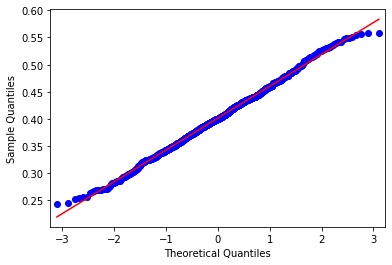

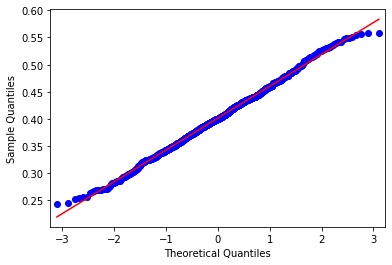

In [37]:
sm.qqplot(cnn_subjectivity, line ='s') 

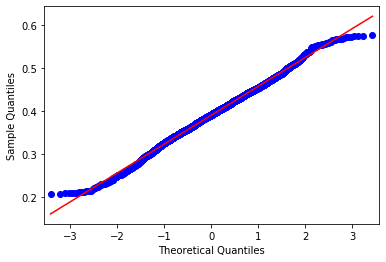

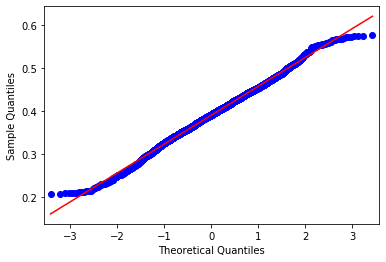

In [38]:
sm.qqplot(nytimes_subjectivity, line ='s') 